# Infer trained model on pedestrian images

In [2]:
import io
import numpy as np
import PIL
from PIL import Image
import requests
import torch
import openpifpaf
from os import listdir
from os.path import isfile, join
from tensorflow import keras
import os
import keras.backend as K

In [10]:
def get_cropped_ped(image_path, return_shape = (224, 224)):
    '''Returns the cropped image from the path of an image with pedestrian in surroundings
    '''
    # open image and convert to RGB - model is trained on RGB images
    pil_im = Image.open(image_path).convert("RGB")
    im = np.asarray(pil_im)

    # use openpifpaf to get image bounding box - can use other, but pose estimation is a needed result
    predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16')
    predictions, gt_anns, image_meta = predictor.pil_image(pil_im)

    # return None if no prediction
    if len(predictions) == 0: return
    if predictions[0].score < 0.5: return
    
    # perform the crop
    bbox = predictions[0].bbox()
    padding = 0.1
    
    l_x = bbox[0] - padding * bbox[2]
    l_y = bbox[1] - padding * bbox[3]
    r_x = l_x + (1 + 2 * padding) * bbox[2]
    r_y = l_y + (1 + 2 * padding) * bbox[3]

    if l_x < 0: l_x = 0
    if l_y < 0: l_y = 0
    if r_x > pil_im.width: r_x = pil_im.width
    if r_y > pil_im.height: r_y = pil_im.height
        
    cropped = pil_im.crop((l_x, l_y, r_x, r_y))
    cropped = cropped.resize(return_shape)
    
    return cropped

def predict_smato(cropped_image, model):
    '''Returns True (has smartphone) or False based on the model
    '''
    im = np.asarray(cropped_image) * 1.0/255.0
    im = im.reshape((1, 224, 224, 3))
    prediction = model.predict(im)[0][0]
    print("Raw prediction results: ", prediction)
    return prediction >= 0.5

def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall)/(precision + recall + K.epsilon())
    return f1_val

### Load Model from saved path

In [8]:
# load model
model_path = "saved_models/smato_efficientnet_m2/"
model = keras.models.load_model(model_path, custom_objects = {"f1": f1})

### Test case for pedestrain with smartphone

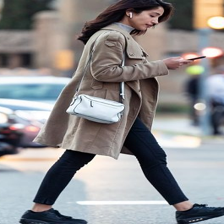

In [11]:
# for true pedestrian
im_path = "infer/test_true.png"
cropped_image = get_cropped_ped(im_path)

# show cropped image
display(cropped_image)

In [6]:
# Predict - expected result is True
result = predict_smato(cropped_image, model)
print("Holding smartphone: ", result)

Raw prediction results:  0.98176944
Holding smartphone:  True


### Test case for pedestrain without smartphone

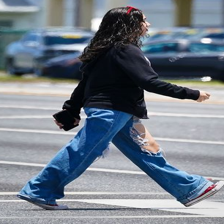

In [8]:
# for true pedestrian
im_path = "infer/test_false_4.png"
cropped_image = get_cropped_ped(im_path)

# show cropped image
display(cropped_image)

In [9]:
## Predict - expected result is False
result = predict_smato(cropped_image, model)
print("Holding smartphone: ", result)

Raw prediction results:  0.027280372
Holding smartphone:  False
